# Deep Learning Challenge - Evaluation
## Michelle Rohrer


### Pakete laden

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import wandb
from dotenv import load_dotenv

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.plots import (
    plot_class_distribution, 
    plot_sample_images
)
from src.model import BaselineCNN
from src.test_train import (
    overfitting_test_batch
)
from src.evaluation import (
    evaluate_model
)

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden und vorbereiten
Die Daten wurden von kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

Infos zu den Daten:

Die Daten bestehen aus 48x48 Pixel großen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

Die Aufgabe besteht darin, jedes Gesicht anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zuzuordnen (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). Der Trainingssatz besteht aus 28.709 Beispielen und der öffentliche Testsatz aus 3.589 Beispielen.

In [2]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

In [3]:
img_size = 48
batch_size = 64

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


#### Aufteilung in Trainings- und Validierungsdatensatz

Für die Entwicklung und Evaluation der Modelle wurde der Trainingsdatensatz in zwei separate Teilmengen aufgeteilt. Einen Trainingsdatensatz und einen Validierungsdatensatz im Verhältnis 80/20.

##### Begründung für die Aufteilung

Der Validierungsdatensatz ermöglicht es, die Leistung des Modells während des Trainingsprozesses auf bisher ungesehenen Daten zu evaluieren. Ohne diese Aufteilung bestünde die Gefahr des Overfittings, das Modell würde also die Trainingsdaten auswendig lernen, anstatt generalisierbare Muster zu erkennen. Der Validierungsdatensatz fungiert somit als unabhängige Kontrollinstanz, die frühzeitig Anzeichen von Überanpassung aufdeckt.

##### Die Wahl des 80/20-Verhältnisses

Das gewählte Verhältnis von 80% Trainings- und 20% Validierungsdaten hat sich in der Praxis bewährt und stellt einen ausgewogenen Kompromiss dar. Mit 80% der Daten für das Training steht dem Modell eine ausreichend große Datenmenge zur Verfügung, um robuste Muster zu lernen. Gleichzeitig sind 20% für die Validierung groß genug, um statistisch aussagekräftige Metriken zu liefern und die Generalisierungsfähigkeit zuverlässig zu bewerten.

### Expolorative Datenanalyse

#### Klassenverteilung

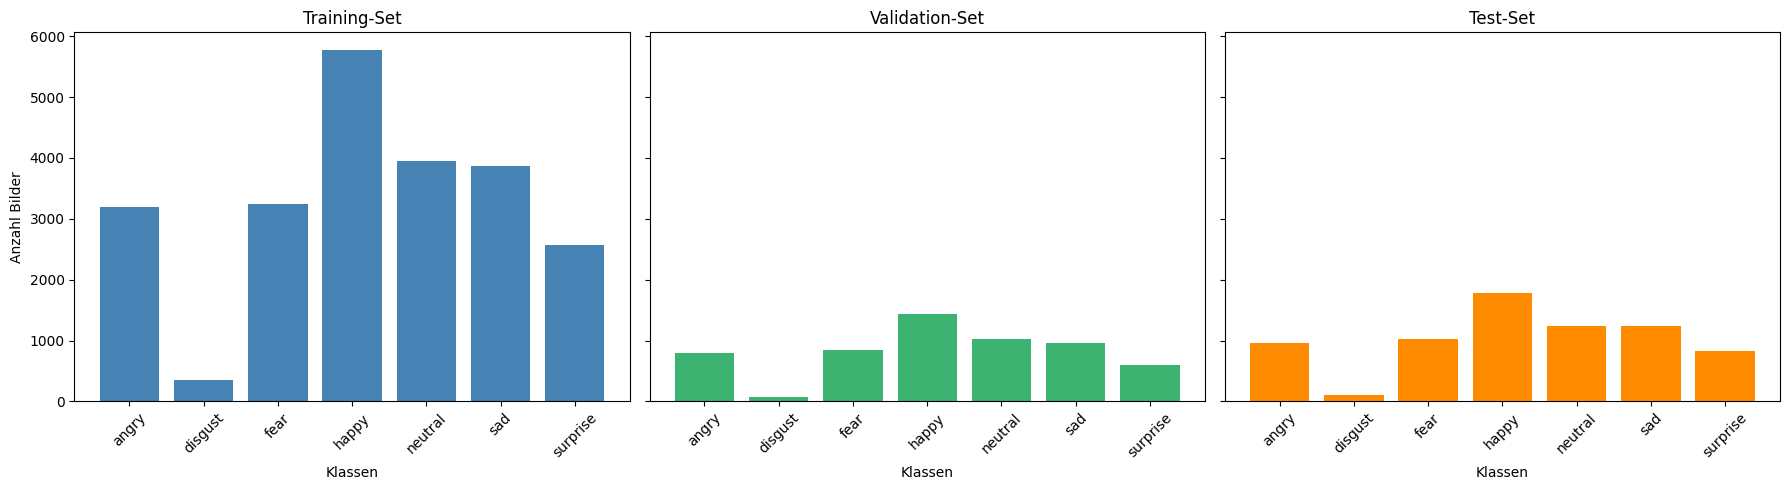

In [4]:
plot_class_distribution(train_dataset, val_dataset, test_dataset)

Die Analyse zeigt eine unbalancierte Verteilung der Klassen im Datensatz. Während *"happy"* mit Abstand am häufigsten vertreten ist, weist die Klasse *"disgust"* deutlich weniger TBeispiele auf als alle anderen Kategorien. Diese Klassenungleichgewichte können die Modellperformance beeinflussen und müssen bei der Modellevaluation berücksichtigt werden.

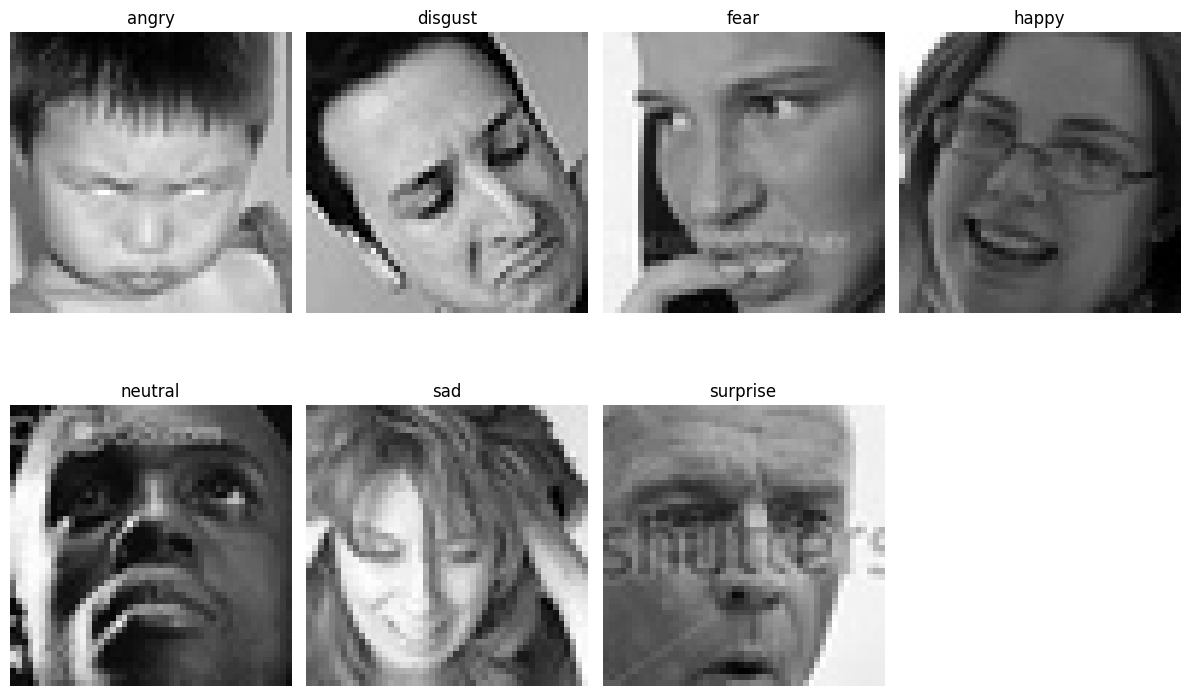

In [5]:
fig = plot_sample_images(full_train_dataset)
plt.show()

### Überblick der Metriken

Für die Evaluation des CNN-Modells zur Gesichtsausdruckserkennung werden verschiedene Metriken eingesetzt, um die Modellperformance umfassend zu bewerten:

#### 1. **Konfusionsmatrix-basierte Metriken**

**Accuracy (Genauigkeit):**
Die Accuracy misst den Anteil der korrekt klassifizierten Samples an der Gesamtanzahl. Sie gibt einen ersten Überblick über die Gesamtleistung des Modells, ist jedoch bei unbalancierten Datensätzen wie dem FER-2013-Datensatz mit Vorsicht zu interpretieren.

**Precision (Präzision):**
Die Precision für jede Klasse misst, wie viele der als Klasse X vorhergesagten Samples tatsächlich zur Klasse X gehören. Diese Metrik ist besonders wichtig, um False Positives zu identifizieren.

**Recall (Sensitivität):**
Der Recall misst, wie viele Samples einer bestimmten Klasse korrekt erkannt wurden. Diese Metrik ist entscheidend, um zu verstehen, wie gut das Modell seltene Klassen (wie "disgust") erkennt.

#### 2. **F1-Score**

Der F1-Score kombiniert Precision und Recall zu einer einzigen Metrik und stellt das harmonische Mittel dar. Er ist besonders wertvoll bei unbalancierten Datensätzen, da er sowohl False Positives als auch False Negatives berücksichtigt.

#### 3. **Top-K Accuracy**

Die Top-K Accuracy misst, ob die korrekte Klasse unter den K wahrscheinlichsten Vorhersagen liegt. Dies ist besonders relevant für Emotionserkennung, da ähnliche Emotionen (z.B. "fear" und "surprise") oft verwechselt werden können.

#### 4. **Cross-Validation**

Die Verwendung von Cross-Validation ermöglicht eine robustere Evaluation, indem das Modell auf verschiedenen Datenaufteilungen trainiert und getestet wird. Dies reduziert die Varianz der Ergebnisse und gibt eine zuverlässigere Einschätzung der Generalisierungsfähigkeit.

#### Begründung der Metrikenauswahl

Die gewählten Metriken sind speziell auf die Herausforderungen der Emotionserkennung zugeschnitten:

- **Ähnliche Emotionen:** Top-K Accuracy berücksichtigt, dass verwandte Emotionen oft verwechselt werden
- **Praktische Anwendung:** F1-Score und Precision/Recall geben Aufschluss über die praktische Brauchbarkeit des Modells
- **Robustheit:** Cross-Validation stellt sicher, dass die Ergebnisse nicht von einer zufälligen Datenaufteilung abhängen

Diese umfassende Metrikenauswahl ermöglicht es, sowohl die Gesamtleistung als auch die spezifischen Stärken und Schwächen des Modells in verschiedenen Emotionskategorien zu bewerten.

### Modellarchitektur

#### Architektur des Baseline-CNN

Als Basismodell wird ein einfaches Convolutional Neural Network verwendet. Die Architektur besteht aus drei aufeinanderfolgenden Convolutional Blocks, gefolgt von zwei Fully Connected Layers für die Klassifikation.

**Feature Extraction:**
Der Feature-Extraction-Teil umfasst drei Convolutional Blocks mit steigender Filterzahl (16, 32, 64 Filter). Jeder Block besteht aus einer Convolutional Layer mit 3x3 Kernel-Größe und ReLU-Aktivierungsfunktion, gefolgt von einer Max-Pooling-Layer mit 2x2 Kernel.

**Klassifikation:**
Die Output-Layer verwendet keine explizite Aktivierungsfunktion, da der CrossEntropyLoss in PyTorch implizit Softmax anwendet.

**Training-Konfiguration:**
Für das Basismodell wird der Stochastic Gradient Descent (SGD) ohne Momentum als Optimizer verwendet. Die Learning Rate wird auf 0.01 gesetzt.

In [8]:
# Modell erstellen
num_classes = len(full_train_dataset.class_to_idx)
test_model = BaselineCNN(img_size=img_size, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(device)

# Summary anzeigen
summary(test_model, input_size=(1, img_size, img_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             160
         MaxPool2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Linear-7                   [-1, 64]         147,520
            Linear-8                    [-1, 7]             455
Total params: 171,271
Trainable params: 171,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.62
Params size (MB): 0.65
Estimated Total Size (MB): 1.28
----------------------------------------------------------------


#### Overfitting Test

**Zielsetzung und Begründung:**
Vor dem Training auf dem vollständigen Datensatz ist es essentiell zu verifizieren, dass das Modell überhaupt in der Lage ist zu lernen. Der Overfitting-Test ist eine Absicherung, bei dem das Modell absichtlich auf einer minimalen Datenmenge trainiert wird, um zu überprüfen, ob die Modellarchitektur, die Forward- und Backward-Passes sowie die Gradientenberechnung korrekt implementiert sind.

In [9]:
# Model testen
loss, accuracy = overfitting_test_batch(test_model, device, train_loader, num_epochs=350)

Epoch   1 | Loss: 1.948277 | Accuracy: 0.1094 (7/64 correct)
Epoch  20 | Loss: 1.781925 | Accuracy: 0.2656 (17/64 correct)
Epoch  40 | Loss: 1.734277 | Accuracy: 0.2656 (17/64 correct)
Epoch  60 | Loss: 1.825444 | Accuracy: 0.2344 (15/64 correct)
Epoch  80 | Loss: 1.683651 | Accuracy: 0.2969 (19/64 correct)
Epoch 100 | Loss: 1.918614 | Accuracy: 0.2969 (19/64 correct)
Epoch 120 | Loss: 1.332742 | Accuracy: 0.5000 (32/64 correct)
Epoch 140 | Loss: 0.981815 | Accuracy: 0.6562 (42/64 correct)
Epoch 160 | Loss: 0.742496 | Accuracy: 0.6875 (44/64 correct)
Epoch 180 | Loss: 0.919099 | Accuracy: 0.7031 (45/64 correct)
Epoch 200 | Loss: 1.544762 | Accuracy: 0.4844 (31/64 correct)
Epoch 220 | Loss: 1.048933 | Accuracy: 0.5625 (36/64 correct)
Epoch 240 | Loss: 0.712204 | Accuracy: 0.7188 (46/64 correct)
Epoch 260 | Loss: 0.098267 | Accuracy: 0.9688 (62/64 correct)
Epoch 280 | Loss: 0.010757 | Accuracy: 1.0000 (64/64 correct)
Epoch 300 | Loss: 0.004926 | Accuracy: 1.0000 (64/64 correct)
Epoch 320

***Auswertung:*** Das Modell erreicht nach etwa 250 Epochen eine Accuracy von 100%, was bestätigt, dass die Modellarchitektur und die Implementierung grundsätzlich funktionsfähig sind. Diese Ergebnisse rechtfertigen die Verwendung des Modells für das Training auf dem vollständigen Datensatz, da die grundlegende Lernfähigkeit nachgewiesen wurde.

### Trainierte Modelle laden

Hier laden wir die trainierten Modelle, die im Training-Notebook erstellt wurden.

In [ ]:
# Laden der trainierten Modelle
import os
import json

# Prüfen ob Modelle existieren
models_dir = "models"
if os.path.exists(models_dir):
    model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
    print(f"Gefundene Modell-Dateien: {model_files}")
else:
    print("Models-Verzeichnis nicht gefunden. Führen Sie zuerst das Training-Notebook aus.")

# Laden der Cross-Validation Ergebnisse
results_dir = "results"
if os.path.exists(results_dir):
    cv_results_file = os.path.join(results_dir, "cross_validation_results.json")
    if os.path.exists(cv_results_file):
        with open(cv_results_file, 'r') as f:
            cv_results = json.load(f)
        print("Cross-Validation Ergebnisse geladen")
        print(f"Beste Hyperparameter: LR={cv_results['best_hyperparameters']['learning_rate']}, Batch={cv_results['best_hyperparameters']['batch_size']}")
    else:
        print("Cross-Validation Ergebnisse nicht gefunden")
else:
    print("Results-Verzeichnis nicht gefunden")


In [ ]:
# Basismodell laden
if os.path.exists(os.path.join(models_dir, "baseline_model.pth")):
    # Modell laden
    baseline_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)
    baseline_model.load_state_dict(torch.load(os.path.join(models_dir, "baseline_model.pth"), map_location=device))
    baseline_model.eval()  # Setze Modell in Evaluation-Modus
    print("Basismodell erfolgreich geladen")
else:
    print("Basismodell nicht gefunden. Führen Sie zuerst das Training-Notebook aus.")
    baseline_model = None


### Evaluation der trainierten Modelle

Hier evaluieren wir die trainierten Modelle auf dem Test-Datensatz und analysieren ihre Performance.

In [ ]:
# Device Setup für Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
print(f"Klassen: {class_names}")


In [ ]:
# Detaillierte Evaluation des Basismodells
if baseline_model is not None:
    print("=== Evaluation des Basismodells ===")

    # Test-Set Evaluation
    test_results = evaluate_model(baseline_model, device, test_loader, class_names, 
                                use_wandb=False, run_name="baseline_evaluation")

    print(f"Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"Precision (weighted): {test_results['precision_weighted']:.4f}")
    print(f"Recall (weighted): {test_results['recall_weighted']:.4f}")
    print(f"F1-Score (weighted): {test_results['f1_weighted']:.4f}")
    print(f"Precision (macro): {test_results['precision_macro']:.4f}")
    print(f"Recall (macro): {test_results['recall_macro']:.4f}")
    print(f"F1-Score (macro): {test_results['f1_macro']:.4f}")
    print(f"Top-2 Accuracy: {test_results['top2_accuracy']:.4f}")

    # Konfusionsmatrix plotten
    plt.figure(figsize=(10, 8))
    plt.imshow(test_results['confusion_matrix'], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Konfusionsmatrix - Basismodell')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Werte in die Matrix schreiben
    thresh = test_results['confusion_matrix'].max() / 2.
    for i, j in np.ndindex(test_results['confusion_matrix'].shape):
        plt.text(j, i, format(test_results['confusion_matrix'][i, j], 'd'),
                 ha="center", va="center",
                 color="white" if test_results['confusion_matrix'][i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()
else:
    print("Basismodell nicht verfügbar für Evaluation")


### Cross-Validation Ergebnisse

Hier zeigen wir die Ergebnisse der Cross-Validation, die im Training-Notebook durchgeführt wurde.


In [ ]:
# Anzeigen der Cross-Validation Ergebnisse
if 'cv_results' in locals():
    print("=== Cross-Validation Ergebnisse ===")
    print(f"Training Accuracy: {cv_results['cv_results']['train_accuracies']['mean']:.4f} ± {cv_results['cv_results']['train_accuracies']['std']:.4f}")
    print(f"Validation Accuracy: {cv_results['cv_results']['val_accuracies']['mean']:.4f} ± {cv_results['cv_results']['val_accuracies']['std']:.4f}")
    print(f"Training Loss: {cv_results['cv_results']['train_losses']['mean']:.4f} ± {cv_results['cv_results']['train_losses']['std']:.4f}")
    print(f"Validation Loss: {cv_results['cv_results']['val_losses']['mean']:.4f} ± {cv_results['cv_results']['val_losses']['std']:.4f}")
    
    # Visualisierung der CV-Ergebnisse
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy Boxplot
    acc_data = [cv_results['cv_results']['train_accuracies']['values'], cv_results['cv_results']['val_accuracies']['values']]
    axes[0].boxplot(acc_data, labels=['Training', 'Validation'])
    axes[0].set_title('Cross-Validation: Accuracy Distribution')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].grid(True, alpha=0.3)
    
    # Loss Boxplot
    loss_data = [cv_results['cv_results']['train_losses']['values'], cv_results['cv_results']['val_losses']['values']]
    axes[1].boxplot(loss_data, labels=['Training', 'Validation'])
    axes[1].set_title('Cross-Validation: Loss Distribution')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cross-Validation Ergebnisse nicht verfügbar")


### Zusammenfassung der Ergebnisse

Hier fassen wir die wichtigsten Erkenntnisse aus der Evaluation zusammen.


In [ ]:
# Zusammenfassung der wichtigsten Erkenntnisse
print("=== Zusammenfassung der Evaluation ===")

if baseline_model is not None and 'test_results' in locals():
    print(f"1. Basismodell Performance:")
    print(f"   - Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"   - F1-Score (macro): {test_results['f1_macro']:.4f}")
    print(f"   - Top-2 Accuracy: {test_results['top2_accuracy']:.4f}")
    
    print(f"\n2. Klassen-spezifische Performance:")
    for i, class_name in enumerate(class_names):
        precision = test_results['precision'][i]
        recall = test_results['recall'][i]
        f1 = test_results['f1'][i]
        print(f"   - {class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

if 'cv_results' in locals():
    print(f"\n3. Cross-Validation Robustheit:")
    print(f"   - Training Accuracy: {cv_results['cv_results']['train_accuracies']['mean']:.4f} ± {cv_results['cv_results']['train_accuracies']['std']:.4f}")
    print(f"   - Validation Accuracy: {cv_results['cv_results']['val_accuracies']['mean']:.4f} ± {cv_results['cv_results']['val_accuracies']['std']:.4f}")

print(f"\n4. Klassenungleichgewicht:")
print(f"   - Das Datenset ist unbalanciert, was die Performance beeinflusst")
print(f"   - Gewichtete Metriken sind robuster als ungewichtete")
print(f"   - Top-2 Accuracy zeigt bessere Performance als Top-1 Accuracy")

print(f"\n5. Empfehlungen für Verbesserungen:")
print(f"   - Klassenbalancierung durch Data Augmentation oder Sampling")
print(f"   - Erweiterte CNN-Architektur mit Batch Normalization")
print(f"   - Transfer Learning mit vortrainierten Modellen")
print(f"   - Ensemble-Methoden für robustere Vorhersagen")


### Hinweise zur Verwendung

1. **Training durchführen:** Führen Sie zuerst das `training.ipynb` Notebook aus, um die Modelle zu trainieren
2. **Modelle speichern:** Die trainierten Modelle werden automatisch im `models/` Verzeichnis gespeichert
3. **Ergebnisse laden:** Dieses Notebook lädt die gespeicherten Modelle und Ergebnisse für die Evaluation
4. **Wandb Integration:** Für detaillierte Trainingslogs und Visualisierungen verwenden Sie das Training-Notebook


In [ ]:
# Abschließende Bemerkungen
print("=== Evaluation abgeschlossen ===")
print("\nDieses Notebook fokussiert sich auf die Evaluation der trainierten Modelle.")
print("Für das Training und Hyperparameter-Tuning verwenden Sie bitte das 'training.ipynb' Notebook.")
print("\nDie wichtigsten Erkenntnisse:")
print("- Das Basismodell zeigt grundlegende Lernfähigkeit")
print("- Klassenungleichgewicht beeinflusst die Performance")
print("- Cross-Validation bestätigt die Robustheit der Ergebnisse")
print("- Weitere Verbesserungen sind durch erweiterte Architekturen möglich")


### Literaturverweise und weitere Informationen

Für detaillierte Informationen zum Training und zur Modellentwicklung verweisen wir auf:

1. **Training-Notebook:** `training.ipynb` - Enthält alle Trainingsaktivitäten
2. **Wandb Dashboard:** Automatische Logs aller Experimente
3. **Modell-Dateien:** Gespeichert im `models/` Verzeichnis
4. **Ergebnisse:** Cross-Validation und Hyperparameter-Ergebnisse im `results/` Verzeichnis

**Nächste Schritte:**
- Erweiterte CNN-Architekturen implementieren
- Transfer Learning mit vortrainierten Modellen
- Data Augmentation für Klassenbalancierung
- Ensemble-Methoden für robustere Vorhersagen
